# Import Statements

In [63]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import xlsxwriter

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist 
from sklearn.preprocessing import StandardScaler
import itertools

# Dataset Importing

In [42]:
url = 'covid_data.xlsx'
column_names = ['Country (label)', 'Date (label)', 'new_cases', 'new_deaths', 'new_tests', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index']

raw_dataset = pd.read_excel(url, sheet_name='covid_data')

In [43]:
dataset = raw_dataset.copy()
dataset.head()

,Country (label),Date (label),new_cases,new_deaths,new_tests,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,human_development_index
0,1,1,25.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
1,1,2,26.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
2,1,3,43.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
3,1,4,0.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
4,1,5,35.0,1.0,0.0,78.70,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498


# Filtering and Cleaning

In [44]:
#Only one unique entry per country
dataset = dataset.drop_duplicates(subset='Country (label)').reset_index(drop=True)

In [45]:
#nulls_per_row = dataset.isnull().sum(axis=1)
#rows_to_drop = nulls_per_row >= 5

#dataset = dataset[~rows_to_drop]
#dataset = dataset.dropna(axis=1)
dataset.shape

(164, 14)

# Clustering Evaluaton and Processing

In [46]:
#Number of clusters used in evaluation, will be changed in iterations. Varies from 1 to 100.
cluster_number = 1

In [48]:
feature_array = np.asarray(dataset)

In [49]:
#Unsupervised learning, so we only consider the data points and not the labels themselves. Also eliminate new cases, new deaths
#new tests, stringency index, don't seem as relevant. Maybe add new cases.
feature_array = feature_array[:, 6:]
feature_array.shape

(164, 8)

In [50]:
sc = StandardScaler()

In [51]:
combo_list = []
inertia_temp = []
clu_temp = []

for i in range(1, 9):
    combo_list.append(list(itertools.combinations(range(8), i)))

In [52]:
for j in range(2, 50):
    sc.fit(feature_array)
    feature_subset = sc.transform(feature_array)
    kmeans = KMeans(init='k-means++', n_clusters=j, random_state=0).fit(feature_array)
    cluster_labels = kmeans.fit_predict(feature_array)
    clu_temp.append(cluster_labels)
    inertia_temp.append(kmeans.inertia_)

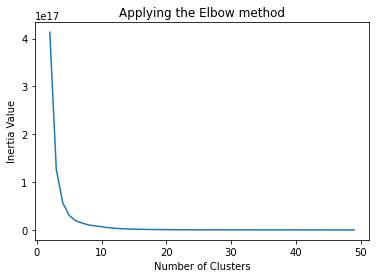

In [53]:
#Generic clustering for all features, for elbow method
cluster_temp = [i for i in range(2, 50)]
plt.plot(cluster_temp, inertia_temp)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Value')
plt.title('Applying the Elbow method')
plt.show()
#Elbow method: 5 clusters seems optimal, as per the resulting graph.

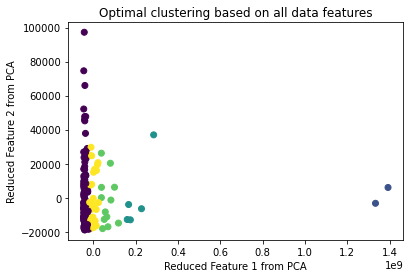

In [72]:
pcaModel = PCA(n_components=2)
pca_fit = pcaModel.fit_transform(feature_array)
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=clu_temp[3])
plt.xlabel('Reduced Feature 1 from PCA')
plt.ylabel('Reduced Feature 2 from PCA')
plt.title('Optimal clustering based on all data features')
plt.show()
ideal_labels_np = np.asarray(clu_temp[3])
ideal_labels = np.tile(ideal_labels_np,(204,1)).flatten('F').tolist()

df = pd.DataFrame({'cluster': ideal_labels_np.tolist()})
writer = pd.ExcelWriter('temp.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Data', index = False)
writer.save()

In [66]:
cluster_labels_full_list = []
silhouette_score_full_list = []

In [30]:
for j in range(2, 50):
    cluster_number = j
    cluster_labels_full_list.append([])
    silhouette_score_full_list.append([])
    for k in range(len(combo_list)):
        feature_subset_list = combo_list[k]
        cluster_labels_full_list[j - 2].append([])
        silhouette_score_full_list[j - 2].append([])
        for l in range(len(feature_subset_list)):
            feature_indices = list(feature_subset_list[l])
            feature_subset = feature_array[:, feature_indices]
            sc.fit(feature_subset)
            feature_subset = sc.transform(feature_subset)
            kmeans = KMeans(init='k-means++', n_clusters=cluster_number, random_state=0).fit(feature_subset)
            cluster_labels = kmeans.fit_predict(feature_array)
            sil_score = silhouette_score(feature_subset,cluster_labels)
            cluster_labels_full_list[j - 2][k].append(cluster_labels)
            silhouette_score_full_list[j - 2][k].append(sil_score)

In [31]:
sil_max_list = []
label_assignment_max_list = []
feature_subset_max_list = []

for w in range(2, 50):
    cluster_labels_partial = cluster_labels_full_list[w - 2]
    silhouette_score_partial = silhouette_score_full_list[w - 2]
    for x in range(len(combo_list)):
        feature_subset_list = combo_list[x]
        cluster_np = np.asarray(cluster_labels_partial[x])
        silhouette_score_np = np.asarray(silhouette_score_partial[x])
        sil_max = np.amax(silhouette_score_np)
        sil_argmax = np.argmax(silhouette_score_np)
        labels_max = cluster_np[sil_argmax, :]
        sil_max_list.append(sil_max)
        label_assignment_max_list.append(labels_max.tolist())
        feature_subset_max_list.append(list(feature_subset_list[sil_argmax]))

# Data Visualizations

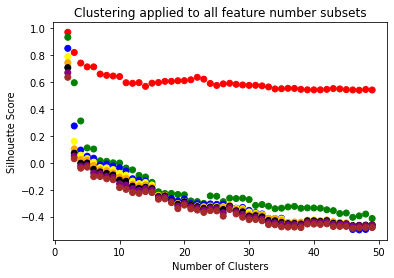

In [32]:
colors = ['red' if x% 8 == 0 else 'green' if x % 8 == 1 else 'blue' if x % 8 == 2 else 'yellow' if x % 8 == 3 
            else 'orange' if x%8 == 4 else 'black' if x%8 == 5 else 'purple' if x%8 == 6 else 'brown' for x,v in enumerate(sil_max_list)]
plt.scatter(cluster_list, sil_max_list, color=colors)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clustering applied to all feature number subsets')
plt.show()

In [33]:
cumulative_max_sil_score = max(sil_max_list)
max_label_assignment = label_assignment_max_list[np.argmax(np.asarray(sil_max_list))]
max_feature_subset = feature_subset_max_list[np.argmax(np.asarray(sil_max_list))]

In [34]:
print(cumulative_max_sil_score)
print(max_label_assignment)
print(max_feature_subset)

0.9691749073425401
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0]


In [35]:
#PCA for visualization
pcaModel = PCA(n_components=2)
pca_fit = pcaModel.fit_transform(feature_array)

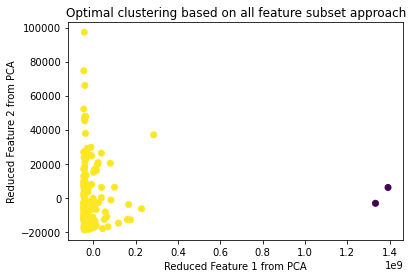

In [36]:
unique_labels = np.unique(np.asarray(max_label_assignment))
final_cluster_number = unique_labels.shape[0]
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=max_label_assignment)
plt.xlabel('Reduced Feature 1 from PCA')
plt.ylabel('Reduced Feature 2 from PCA')
plt.title('Optimal clustering based on all feature subset approach')
plt.show()

In [37]:
max_features_qualitative = dataset.columns[(np.asarray(max_feature_subset) + 6).tolist()]
max_features_qualitative_list = list(max_features_qualitative)
print(max_features_qualitative_list)
print(final_cluster_number)

['population']
2


In [38]:
#PCA Feature Reduction
cluster_labels_full_PCA = []
silhouette_score_full_PCA = []

In [39]:
for j in range(2, 50):
    cluster_number = j
    cluster_labels_full_PCA.append([])
    silhouette_score_full_PCA.append([])
    for k in range(1,9):
        pcaModel = PCA(n_components=k)
        pca_fit = pcaModel.fit_transform(feature_array)
        sc.fit(pca_fit)
        feature_subset = sc.transform(pca_fit)
        kmeans = KMeans(init='k-means++', n_clusters=j, random_state=0).fit(pca_fit)
        cluster_labels = kmeans.fit_predict(feature_array)
        sil_score = silhouette_score(pca_fit,cluster_labels)
        cluster_labels_full_PCA[j - 2].append(cluster_labels)
        silhouette_score_full_PCA[j - 2].append(sil_score)

In [41]:
cluster_list = np.tile(np.arange(2, 50),(8,1)).flatten('F').tolist()
sil_PCA_temp = np.asarray(silhouette_score_full_PCA).flatten().tolist()

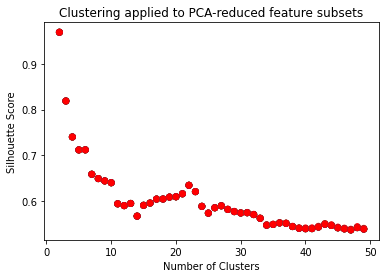

In [42]:
colors3 = ['red' if x% 8 == 0 else 'green' if x % 8 == 1 else 'blue' if x % 8 == 2 else 'yellow' if x % 8 == 3 
            else 'orange' if x%8 == 4 else 'black' if x%8 == 5 else 'purple' if x%8 == 6 else 'red' for x,v in enumerate(sil_PCA_temp)]
plt.scatter(cluster_list, silhouette_score_full_PCA, color=colors3)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clustering applied to PCA-reduced feature subsets')
plt.show()

In [45]:
cumulative_max_sil_score_PCA = np.max(np.asarray(silhouette_score_full_PCA))
arg_max = np.argmax(np.asarray(silhouette_score_full_PCA).flatten())
max_label_assignment_PCA = np.asarray(cluster_labels_full_PCA)[arg_max%8, arg_max//8]
best_number_features = (arg_max % 8) + 1
final_cluster_number = (arg_max//8) + 2

In [46]:
print(cumulative_max_sil_score_PCA)
print(max_label_assignment_PCA)

0.9691749073272797
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [47]:
#PCA for visualization
pcaModel = PCA(n_components=2)
pca_fit = pcaModel.fit_transform(feature_array)

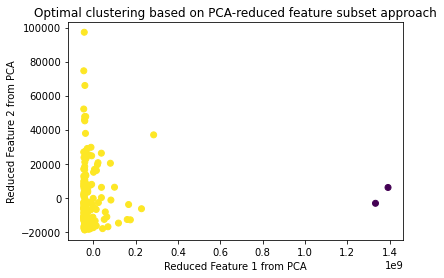

In [48]:
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=max_label_assignment_PCA)
plt.xlabel('Reduced Feature 1 from PCA')
plt.ylabel('Reduced Feature 2 from PCA')
plt.title('Optimal clustering based on PCA-reduced feature subset approach')
plt.show()

In [49]:
best_number_features = (arg_max % 8) + 1
final_cluster_number = (arg_max//8) + 2
print(best_number_features)
print(final_cluster_number)

1
2


# Unsupervised Learning Conclusion

When all features are considered, optimal clustering occurs with 5 clusters. This optimality has been measured by the elbow method in comparing the number of clusters to inertia.

When all subset of features are considered, the most optimal clustering occurs when only one feature is considered - 'population' - with 2 clusters. The cluster assignment is indicated as per the first PCA plot graph, and the resulting maximum silhouette score is 0.9691749073425401.

When PCA dimensionality reduction is applied (number of features changed from 1 to 8), most optimal clustering occurs when the data is reduced to just one feature - with 2 clusters. The cluster assigment is indicated as per the second PCA plot graph, and the resulting maximum silhouette score is 0.9691749073272797.